# Temperature and metallic systems

In this example we consider the modeling of a magnesium lattice
as a simple example for a metallic system.
For our treatment we will use the PBE exchange-correlation functional.
First we import required packages and setup the lattice.
Again notice that DFTK uses the convention that lattice vectors are
specified column by column.

In [1]:
using DFTK
using Plots
using PseudoPotentialData
using Unitful
using UnitfulAtomic

a = 3.01794  # Bohr
b = 5.22722  # Bohr
c = 9.77362  # Bohr
lattice = [[-a -a  0]; [-b  b  0]; [0   0 -c]]

pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
Mg = ElementPsp(:Mg, pseudopotentials)
atoms     = [Mg, Mg]
positions = [[2/3, 1/3, 1/4], [1/3, 2/3, 3/4]];

Next we build the PBE model and discretize it.
Since magnesium is a metal we apply a small smearing
temperature to ease convergence using the Fermi-Dirac
smearing scheme.

In [2]:
kgrid = KgridSpacing(0.9 / u"Å")    # Minimal spacing of k-points,
#                                      in units of wavevectors (inverse Bohrs)
temperature = 0.01                    # Smearing temperature in Hartree
Ecut = 10                             # Kinetic energy cutoff in Hartree
smearing = DFTK.Smearing.FermiDirac() # Smearing method
#                                      also supported: Gaussian,
#                                      MarzariVanderbilt,
#                                      and MethfesselPaxton(order)

model = model_DFT(lattice, atoms, positions;
                  functionals=[:gga_x_pbe, :gga_c_pbe], temperature, smearing)
basis = PlaneWaveBasis(model; Ecut, kgrid);

Note, that in this example both the `Ecut` as well as the minimal $k$-point spacing
`0.9 / u"Å"` far too large to give a converged result. In the online documentation we
have used these small values to obtain a fast execution time.

> **Ecut and kgrid are optional**
>
> Both the `Ecut` and the `kgrid` keyword argument in `PlaneWaveBasis`
> are optional. If the user does not specify these values, DFTK will
> try to determine reasonable default values:
> - Kgrid default:`kgrid=KgridSpacing(2π * 0.022 / u"bohr")`, which
>   usually gives reasonable results for a first calculation.
> - Ecut default: DFTK will consult the [PseudoPotentialData.jl](https://github.com/JuliaMolSim/PseudoPotentialData.jl)
>   library for a recommended kinetic energy cutoff and use the maximal
>   value over all atoms of the calculation.   See the Pseudopotentials
>   chapter for more details on using pseudopotentials with DFTK.
>   For cases where no recommended values can be determined,
>   DFTK will throw an error and expects the user to manually provide
>   a value for `Ecut`.
> Therefore we could also construct a more reasonable basis as follows:

In [3]:
basis_default = PlaneWaveBasis(model)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 2
    num. fft   threads   : 1

    Ecut                 : 42.0 Ha
    fft_size             : (40, 40, 60), 96000 total points
    kgrid                : MonkhorstPack([9, 9, 5])
    num.   red. kpoints  : 405
    num. irred. kpoints  : 36

    Estimated memory usage (per MPI process):
        nonlocal projectors  :   35.1MiB
        single ψ             :   30.7MiB
        single ρ             :    750KiB
        peak memory (SCF)    :    110MiB
    
    Discretized Model(gga_x_pbe+gga_c_pbe, 3D):
        lattice (in Bohr)    : [-3.01794  , -3.01794  , 0         ]
                               [-5.22722  , 5.22722   , 0         ]
                               [0         , 0         , -9.77362  ]
        unit cell volume     : 308.37 Bohr³
    
        atoms                : Mg₂
        pseudopot. family

As can be seen the default discretisation selects the much finer discretisation
parameters `Ecut=42` and `kgrid=[9, 9, 5]`. In production calculations it
is often advisable to refine these values by Performing a convergence study.

> **Getting the above output in a script**
>
> The above detailed `basis` printing with parallelisation information,
> discretisation parameters, structure and model is the default output generated
> when returning a `basis` in an interactive session or a Pluto / Jupyter notebook.
> In order to obtain the same information in a script (e.g. to `stdout`) execute
> ```julia
> show(stdout, "text/plain", basis)
> ```

Finally we run the SCF. Two magnesium atoms in
our pseudopotential model result in four valence electrons being explicitly
treated. Nevertheless this SCF will solve for eight bands by default
in order to capture partial occupations beyond the Fermi level due to
the employed smearing scheme. In this example we use a damping of `0.8`.
The default `LdosMixing` should be suitable to converge metallic systems
like the one we model here. For the sake of demonstration we still switch to
Kerker mixing here.

In [4]:
scfres = self_consistent_field(basis, damping=0.8, mixing=KerkerMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -107.0208210267                    0.39    5.8    4.97s
  2   -107.6655392251       -0.19       -0.47    3.5    3.11s
  3   -107.6687202399       -2.50       -1.59    2.8   81.6ms
  4   -107.6687497599       -4.53       -2.76    1.0   93.4ms
  5   -107.6687513570       -5.80       -3.39    4.0    104ms
  6   -107.6687514219       -7.19       -3.88    2.3   81.4ms
  7   -107.6687514267       -8.32       -4.68    4.0   89.2ms
  8   -107.6687514272       -9.32       -5.07    3.2    107ms
  9   -107.6687514272      -10.82       -6.21    1.5   77.8ms


In [5]:
scfres.occupation[1]

17-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 1.9999999999999098
 1.9999272441575455
 1.9121680309987714
 6.511419917017358e-17
 6.510817878747105e-17
 7.050055948364711e-18
 7.377376846028498e-19
 7.376802380657e-19
 1.7854031244688638e-19

In [6]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             48.3202519
    AtomicLocal         -101.1884725
    AtomicNonlocal      -19.3973024
    Ewald               -53.8605542
    PspCorrection       1.1973309 
    Hartree             30.7290262
    Xc                  -13.4577024
    Entropy             -0.0113289

    total               -107.668751427183

The fact that magnesium is a metal is confirmed
by plotting the density of states around the Fermi level.
To get better plots, we decrease the k spacing a bit for this step,
i.e. we use a finer k-point mesh with more points.

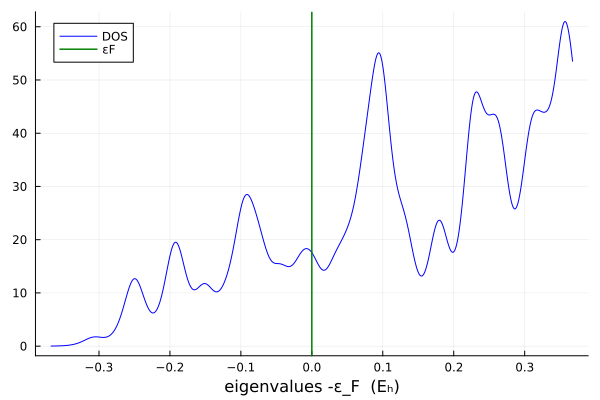

In [7]:
bands = compute_bands(scfres, KgridSpacing(0.7 / u"Å"))
plot_dos(bands)